In [ ]:
#| default_exp extract_spk_emb

## Precompute Whisper transcriptions for VQ bottleneck distilation

Doing transcription means sampling from the Whisper auto-regresive decoder. This is too slow to do for each training batch. Fortunately the trainscriptions are small text snippets so we can precompute them once for the whole dataset.

We use segments from Voice Activity Detection to reduce any boundary issues, the we use webdataset to yields multiple chunks from a FLAC file we only load once. The VAD segments are merged into longer chunks to make Whisper processing more efficent (it always processes 30s at a time)

**Usage:**  
```
python -m whisperspeech.extract_spk_emb librilight-large-wo6454-flac-000002.tar
```

You can pass in either a URL or a local file name. Either way it will expect a `vad` file in the local directory. The result will go into a file in the current directory named after the source file but replacing `flac` with `txt`.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os
from os.path import expanduser
import sys

from fastprogress import progress_bar
from fastcore.script import *
import webdataset as wds
import torch
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

from whisperspeech import vad, utils

from speechbrain.pretrained import EncoderClassifier
from whisperspeech.inference import get_compute_device

/opt/conda/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/opt/conda/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


## Batch processing

Let's put everything above together.

In [ ]:
#| exporti
def calc_len(x):
    x['seconds'] = torch.tensor(x['tend'] - x['tstart'])
    return x

def chunked_dataset(input, bs=16):
    ds = utils.vad_dataset([input]).compose(
        utils.resampler(16000, 'samples_16k'),
        wds.map(calc_len),
        wds.to_tuple('__key__', 'samples_16k', 'seconds'),
        wds.batched(bs),
    )
    dl = DataLoader(ds, num_workers=1, batch_size=None)
    return dl

In [ ]:
dl = chunked_dataset('../cc-small/cc-mix-000000.tar', 'mix')
for keys, samples, seconds in dl: break
keys, samples, seconds

(['cc/7 Sec Riddles/[-hIfETsPxPg] New TYPE Of Riddles： Can You Ace Our New Game？ ？_023',
  'cc/Bon Appetit/[jmntzm5yBYY] Melissa Makes Chicken Afritada ｜ From the Home Kitchen ｜ Bon Appétit_037',
  'cc/7 Sec Riddles/[-hIfETsPxPg] New TYPE Of Riddles： Can You Ace Our New Game？ ？_009',
  'cc/Bon Appetit/[jmntzm5yBYY] Melissa Makes Chicken Afritada ｜ From the Home Kitchen ｜ Bon Appétit_010',
  'cc/7 Sec Riddles/[-hIfETsPxPg] New TYPE Of Riddles： Can You Ace Our New Game？ ？_004',
  'cc/Bon Appetit/[jmntzm5yBYY] Melissa Makes Chicken Afritada ｜ From the Home Kitchen ｜ Bon Appétit_049',
  'cc/Bon Appetit/[jmntzm5yBYY] Melissa Makes Chicken Afritada ｜ From the Home Kitchen ｜ Bon Appétit_000',
  'cc/Bon Appetit/[jmntzm5yBYY] Melissa Makes Chicken Afritada ｜ From the Home Kitchen ｜ Bon Appétit_024',
  'cc/7 Sec Riddles/[-hIfETsPxPg] New TYPE Of Riddles： Can You Ace Our New Game？ ？_033',
  'cc/Bon Appetit/[jmntzm5yBYY] Melissa Makes Chicken Afritada ｜ From the Home Kitchen ｜ Bon Appétit_034',
  

In [ ]:
classifier = EncoderClassifier.from_hparams("speechbrain/spkrec-ecapa-voxceleb",
                                            savedir=os.path.expanduser("~/.cache/speechbrain/"),
                                            run_opts={"device": "cuda"})

In [ ]:
embs = F.normalize(classifier.encode_batch(samples, wav_lens=seconds/30).squeeze(1), dim=-1)

In [ ]:
embs  @ embs.T

tensor([[ 1.0000e+00, -1.5016e-01, -1.0663e-01,  7.4717e-01,  6.6663e-01,
          6.7088e-01,  7.3192e-01,  8.0751e-01, -1.4667e-01, -1.5538e-01,
          7.8594e-01, -1.7131e-01,  4.7389e-02,  3.8923e-01,  8.0528e-02,
          6.8884e-02],
        [-1.5016e-01,  1.0000e+00,  7.4450e-01, -7.8480e-02, -9.2287e-02,
         -4.8926e-02, -1.8269e-01, -1.2868e-01,  6.2437e-01,  7.6687e-01,
         -1.2109e-01,  5.7231e-01,  5.4483e-02, -1.3711e-02,  5.4225e-02,
          1.0608e-01],
        [-1.0663e-01,  7.4450e-01,  1.0000e+00, -9.6316e-02, -8.8784e-02,
         -3.4282e-02, -1.6323e-01, -1.2561e-01,  5.7611e-01,  7.6471e-01,
         -1.1900e-01,  5.1093e-01,  3.6564e-02,  2.1784e-03,  4.5240e-02,
          8.6847e-02],
        [ 7.4717e-01, -7.8480e-02, -9.6316e-02,  1.0000e+00,  6.9144e-01,
          7.3513e-01,  7.2880e-01,  7.7707e-01, -8.8781e-02, -8.2090e-02,
          7.7152e-01, -5.2820e-02,  7.3040e-02,  3.4047e-01,  9.3617e-02,
          1.1111e-01],
        [ 6.6663e-01

In [ ]:
seconds

tensor([ 4.9147, 14.5051,  8.8225,  9.8293,  4.2150,  3.1399,  5.1536,  5.5290,
         4.9317, 12.8499,  7.5085,  2.3379, 17.1672,  1.2287, 29.0785,  3.2935])

In [ ]:
((embs.unsqueeze(1) - embs.unsqueeze(0))**2).sum(-1)

tensor([[0.0000, 2.3003, 2.2133, 0.5057, 0.6667, 0.6582, 0.5362, 0.3850, 2.2933,
         2.3108, 0.4281, 2.3426, 1.9052, 1.2215, 1.8389, 1.8622],
        [2.3003, 0.0000, 0.5110, 2.1570, 2.1846, 2.0979, 2.3654, 2.2574, 0.7513,
         0.4663, 2.2422, 0.8554, 1.8910, 2.0274, 1.8916, 1.7878],
        [2.2133, 0.5110, 0.0000, 2.1926, 2.1776, 2.0686, 2.3265, 2.2512, 0.8478,
         0.4706, 2.2380, 0.9781, 1.9269, 1.9956, 1.9095, 1.8263],
        [0.5057, 2.1570, 2.1926, 0.0000, 0.6171, 0.5297, 0.5424, 0.4459, 2.1776,
         2.1642, 0.4570, 2.1056, 1.8539, 1.3191, 1.8128, 1.7778],
        [0.6667, 2.1846, 2.1776, 0.6171, 0.0000, 0.5634, 0.7283, 0.5234, 2.1465,
         2.2558, 0.5350, 2.0010, 2.0479, 1.2902, 1.8843, 1.7488],
        [0.6582, 2.0979, 2.0686, 0.5297, 0.5634, 0.0000, 0.6402, 0.5659, 2.2220,
         2.0655, 0.5940, 1.9980, 1.9350, 1.3600, 1.8089, 1.7575],
        [0.5362, 2.3654, 2.3265, 0.5424, 0.7283, 0.6402, 0.0000, 0.5028, 2.2943,
         2.3770, 0.4458, 2.2970, 1.92

<matplotlib.image.AxesImage>

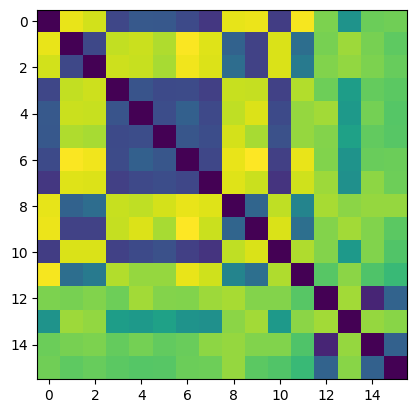

In [ ]:
plt.imshow(((embs.unsqueeze(1) - embs.unsqueeze(0))**2).sum(-1).cpu())

In [ ]:
#| exporti
@call_parse
def process_shard(
    input:str,          # input shard URL/path
    output:str,         # output shard URL/path
    batch_size:int=16,        # batch size
    n_samples:int=None, # limit the number of samples (useful for quick benchmarking)
):
    device = get_compute_device()
    if n_samples is None: total = 'noinfer'
    else: total = n_samples // batch_size

    dl = chunked_dataset(input, bs=batch_size)
    
    classifier = EncoderClassifier.from_hparams("speechbrain/spkrec-ecapa-voxceleb",
                                                savedir=expanduser("~/.cache/speechbrain/"),
                                                run_opts = {"device": device})
    
    with utils.AtomicTarWriter(output) as sink:
        for keys, samples, seconds in progress_bar(dl, total=total):
            with torch.no_grad():
                embs = classifier.encode_batch(samples, wav_lens=seconds/30).squeeze(1)
            for key, emb in zip(keys, embs):
                sink.write({
                    "__key__": key,
                    "spk_emb.npy": emb.cpu().numpy(),
                })
        if n_samples is not None:
            sink.abort = True
        sys.stdout.write("\n")